<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra
<br>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/master/notebooks/EELS/Analysis_Core_Loss.ipynb)

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2020

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes




## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum


Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``version 0.0.4`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer or colab session.

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists without loading nd returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyNSID/ -q
    !pip install git+https://github.com/pycroscopy/sidpy/ -q
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q
    !wget  "https://raw.githubusercontent.com/gduscher/Analysis-of-Transmission-Electron-Microscope-Data/master/example_data/1EELS Acquire (high-loss).dm3" -P /content/example-data/
else:
    # pyTEMlib setup ------------------
    if test_package('sidpy') < '0.0.4':
        !{sys.executable} -m pip install  --upgrade sidpy -q
        print('installed sidpy')
    if test_package('pyNSID') < '0.0.1':
        !{sys.executable} -m pip install  --upgrade  git+https://github.com/pycroscopy/pyNSID -q
        print('Installed pyNSID')
    if test_package('pyTEMlib') < '0.2021.1.':
        !{sys.executable} -m pip install  --upgrade git+https://github.com/pycroscopy/pyTEMlib -q
        print('installed pyTEMlib')
    
# ------------------------------
print('done')

done


### Load the relevant packages

In [1]:
import sys
if 'google.colab' in sys.modules:
    import numpy as np
else:    
    %pylab --no-import-all notebook
    %gui qt

# Import libraries from pyTEMlib
import sidpy

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
import pyTEMlib.viz
if ft.QT_available:
    import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification


# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2021_02_04'

Populating the interactive namespace from numpy and matplotlib


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


pyTEM version:  0.2021.02.22


%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../pyTEMlib/')

## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


In [3]:
# ---- INPUT choices ---- #
Open_Nion_Directory = False  
load_example = True #
mount_google_drive = True
bokeh_plot = False  # using bokeh to plot or not
# ------------------------
if load_example:
    drive_directory = '.'
else:
    drive_directory = ft.get_last_path()
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    Open_Nion_Directory = True
    
    bokeh_plot = True
    if load_example:
        drive_directory = '/content/example-data'
    else:
        drive_directory = 'drive/MyDrive/'

elif not ft.QT_available:
    Open_Nion_Directory = True    

if bokeh_plot == True:
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import LinearAxis, Range1d
    output_notebook()

### Open file widget
if Open_Nion_Directory:
    file_widget = pyTEMlib.file_tools.FileWidget(drive_directory)

C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


sidpy.Dataset of type SPECTRUM with:
 dask.array<01, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (2048,)


<IPython.core.display.Javascript object>


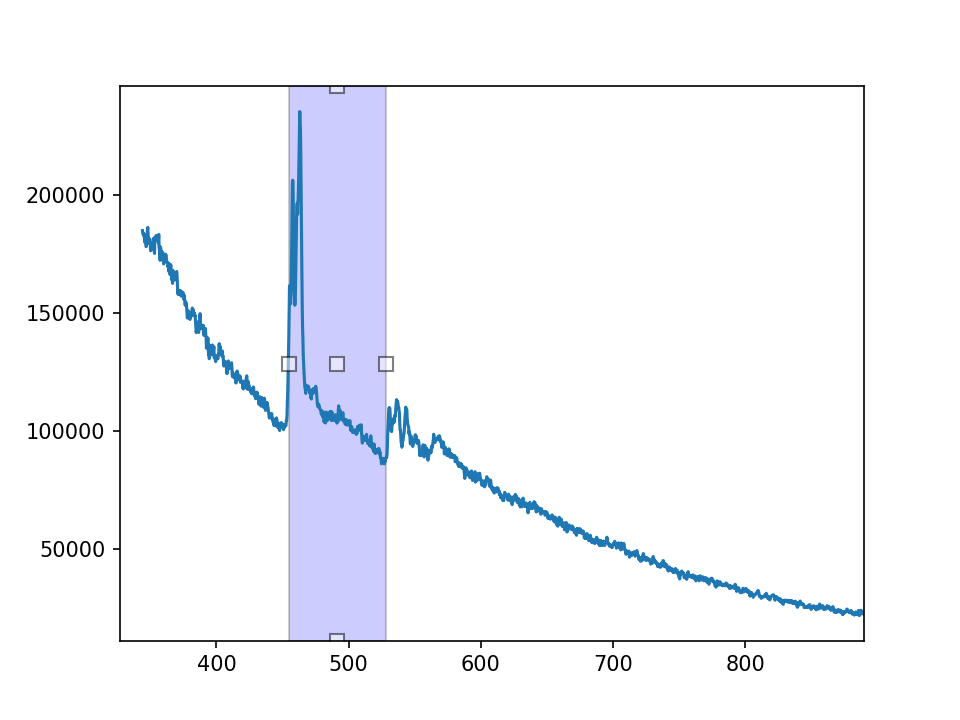

In [4]:
ft.QT_available = True

try:
    dataset.h5_dataset.file.close()
except:
    pass

if Open_Nion_Directory:
    dataset = pyTEMlib.file_tools.open_file(file_widget.file_name)
else:
    dataset = pyTEMlib.file_tools.open_file()

print(dataset)

current_channel = dataset.h5_dataset.parent.parent

if 'experiment' not in dataset.metadata:
    dataset.metadata['experiment']= eels.read_dm3_eels_info(dataset.original_metadata)
# US 200 does not set acceleration voltage correctly.
# comment out next line  for other microscopes
# dataset.metadata['experiment']['acceleration_voltage'] = 200000
if dataset.data_type.name=='SPECTRUM':
    if ft.QT_available:
        info = ieels.InfoDialog(dataset)
    else:
        print('make sure information is correct')
        dataset.view_metadata()

        dataset.view = pyTEMlib.viz.CurveVisualizer(dataset)
        show(dataset.view.fig)
else:
    print('We really need a spectrum here')

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

In [5]:
def update_element(z, dataset):

    edges = dataset.metadata['edges']
    energy_scale = dataset.energy_loss
    zz = eels.get_z(z)
    index = 0
    for key, edge in edges.items():
        if 'Z' in edge:
            index += 1
            if zz == edge['Z']:
                return None

    major_edge = ''
    minor_edge = ''
    all_edges = {}
    x_section = eels.get_x_sections(zz)
    edge_start = 10  # int(15./ft.get_slope(self.energy_scale)+0.5)
    for key in x_section:
        if len(key) == 2 and key[0] in ['K', 'L', 'M', 'N', 'O'] and key[1].isdigit():
            if energy_scale[edge_start] < x_section[key]['onset'] < energy_scale[-edge_start]:
                if key in ['K1', 'L3', 'M5']:
                    major_edge = key
                elif key in ['K1', 'L3', 'M5', 'M3', 'M1', 'N1', 'N3', 'N5', 'N7', 'O1', 'O3', 'O5']:
                    if minor_edge == '':
                        minor_edge = key
                    if int(key[-1]) % 2 > 0:
                        if int(minor_edge[-1]) % 2 == 0 or key[-1] > minor_edge[-1]:
                            minor_edge = key

                all_edges[key] = {'onset': x_section[key]['onset']}

    if major_edge != '':
        key = major_edge
    elif minor_edge != '':
        key = minor_edge
    else:
        print(f'Could not find no edge of {zz} in spectrum')
        return False



    start_exclude = x_section[key]['onset'] - x_section[key]['excl before']
    end_exclude = x_section[key]['onset'] + x_section[key]['excl after']

    edges[str(index)] = {'Z': zz, 'symmetry': key, 'element': eels.elements[zz],
                          'onset': x_section[key]['onset'], 'end_exclude': end_exclude,
                          'start_exclude': start_exclude}
    edges[str(index)]['all_edges'] = all_edges
    edges[str(index)]['chemical_shift'] = 0.0
    edges[str(index)]['areal_density'] = 0.0
    edges[str(index)]['original_onset'] = edges[str(index)]['onset']
    return True

<IPython.core.display.Javascript object>


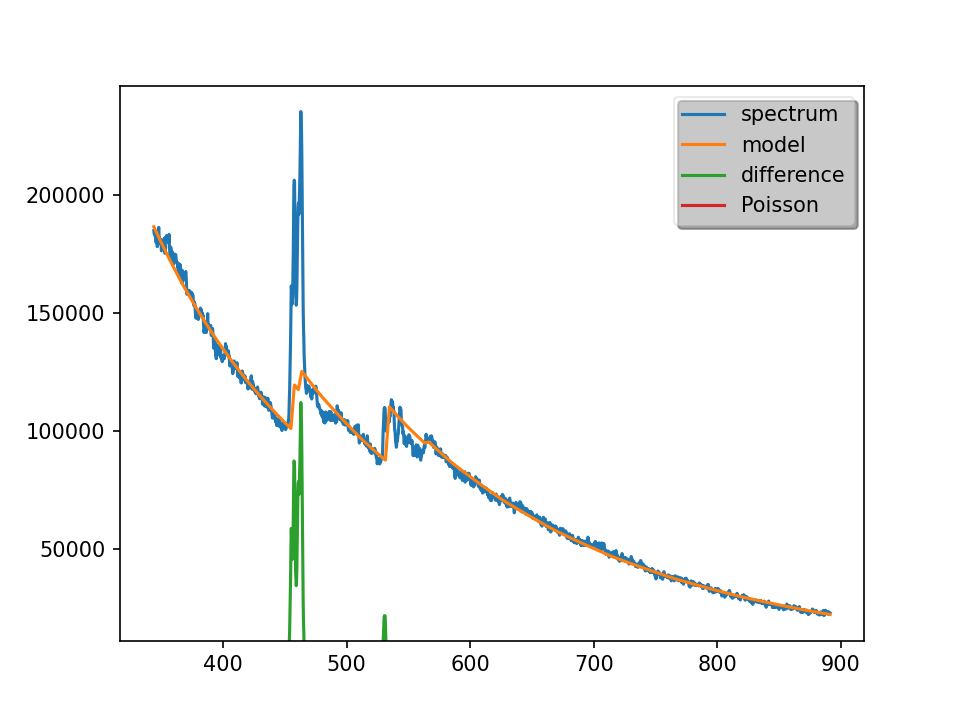

In [6]:

element_list= ['Ti', 'O']
# dataset.metadata['edges'] = {'0': {}, 'model': {}}
ft.QT_available - True
if ft.QT_available:
    composition = ieels.CompositionDialog(dataset)
else:
    if 'edges' not in dataset.metadata or dataset.metadata['edges'] == {}:
        dataset.metadata['edges'] = {'0': {}, 'model': {}}
    edges = dataset.metadata['edges']
    edges['fit_area'] = {'fit_start': dataset.energy_loss[50],
                         'fit_end': dataset.energy_loss[-2]}
    
    print('Adjust onset and exclude parameters for each edge in dictionary dataset.metadata[\'edges\']')
    i = 0
    for element in element_list:
        update_element(element, dataset)
        print(f"{edges[str(i)]['element']:2s}: edges[\'{i}\'][\'onset\']: {edges[str(i)]['onset']}; "+
              f" edges[\'{i}\'][\'start_exclude\']: {edges[str(i)]['start_exclude']}; "+
              f" edges[\'{i}\'][\'end_exclude\'] {edges[str(i)]['end_exclude']} ")
        i+=1



<IPython.core.display.Javascript object>


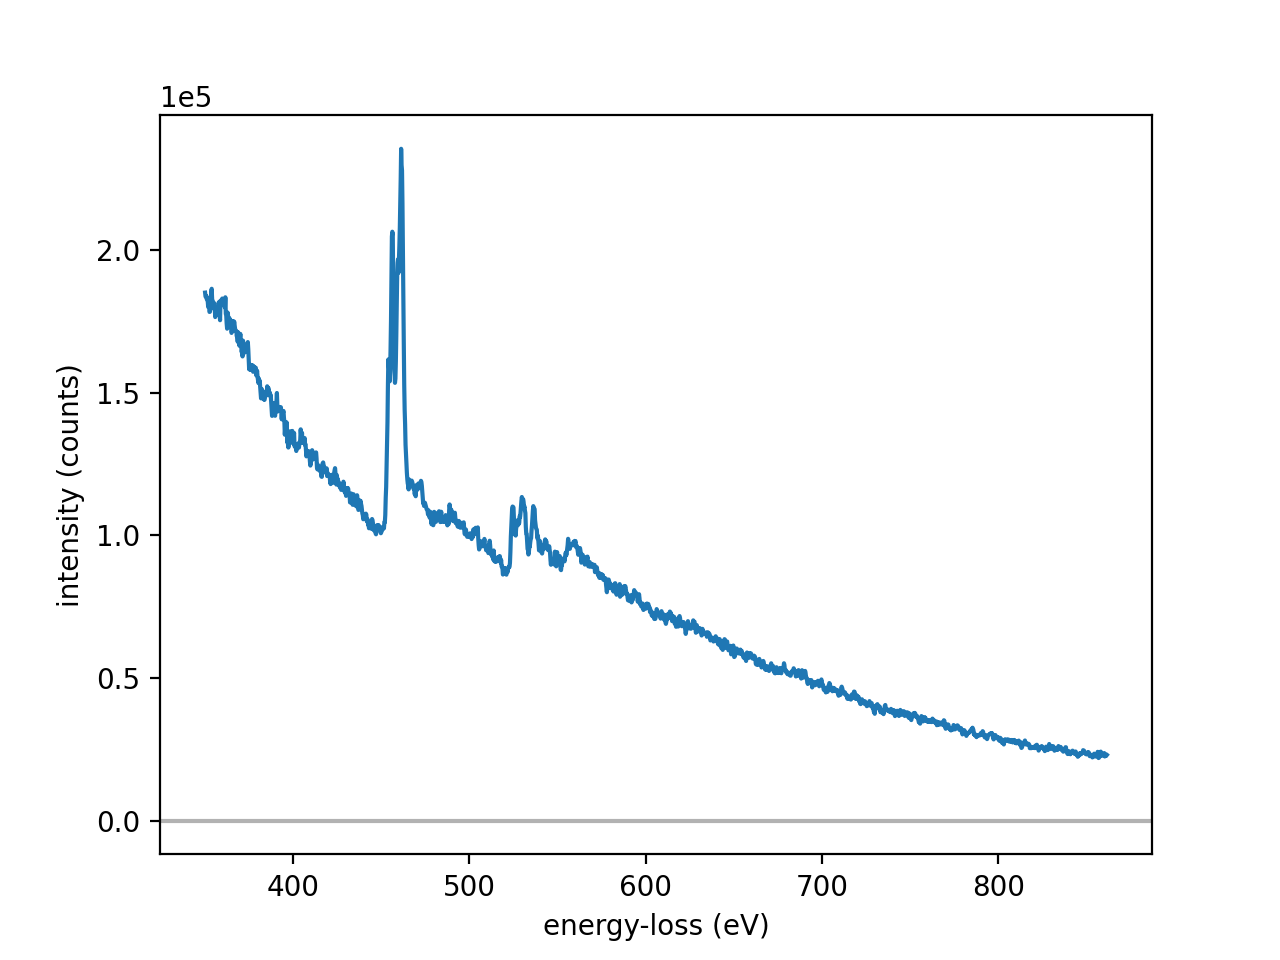

In [86]:
del dataset.metadata['add2plot']
v = ieels.CurveVisualizer(dataset)

In [79]:
print(ft.get_dimensions_by_type('spectral', dataset)[0][2])

IndexError: list index out of range

In [73]:
edges = dataset.metadata['edges'] 
dataset.metadata['add2plot'] = {}
dataset.metadata['add2plot'][1] = {'data': edges['model']['spectrum'], 'legend': 'model'} 
dataset.metadata['add2plot'][2] = {'data': np.array(dataset - edges['model']['spectrum']), 'legend': 'difference'} 

dataset.metadata['add2plot'][3] = {'data': np.array((dataset-edges['model']['spectrum'])/np.sqrt(np.abs(dataset))), 
                                   'legend':'Poisson'}
v.update()

In [35]:
def do_fit(dataset):
    if 'experiment' in dataset.metadata:
        exp = dataset.metadata['experiment']
        if 'convergence_angle' not in exp:
            raise ValueError('need a convergence_angle in experiment of metadata dictionary ')
        alpha = exp['convergence_angle']
        beta = exp['collection_angle']
        beam_kv = exp['acceleration_voltage']
    else:
        raise ValueError('need a experiment parameters in metadata dictionary')
    if 'edges' in dataset.metadata:
        edges = dataset.metadata['edges']
    else:
        raise ValueError('need a edge parameters in metadata dictionary')
    
    energy_scale = dataset.energy_loss.values
    eff_beta = eels.effective_collection_angle(energy_scale, alpha, beta, beam_kv)
  
    edges = eels.make_cross_sections(edges, np.array(energy_scale), beam_kv, eff_beta)

    if dataset.data_type == sidpy.DataType.SPECTRAL_IMAGE:
        spectrum = self.dataset.view.get_spectrum()
    else:
        spectrum = dataset
    edges = eels.fit_edges2(spectrum, energy_scale, edges)
    areal_density = []
    elements = []
    for key in edges:
        if key.isdigit():  # only edges have numbers in that dictionary
            elements.append(edges[key]['element'])
            areal_density.append(edges[key]['areal_density'])
    areal_density = np.array(areal_density)
    out_string = '\nRelative composition: \n'
    for i, element in enumerate(elements):
        out_string += f'{element}: {areal_density[i] / areal_density.sum() * 100:.1f}%  '
    print(out_string)
    print('new')
    dataset.metadata['add2plot'] = {}
    dataset.metadata['add2plot'][1] = {'data': edges['model']['spectrum'], 'legend': 'model'} 
    dataset.metadata['add2plot'][2] = {'data': np.array(spectrum - edges['model']['spectrum']), 'legend': 'difference'} 

    dataset.metadata['add2plot'][3] = {'data': np.array((spectrum-edges['model']['spectrum'])/np.sqrt(spectrum)), 
                                       'legend':'Poisson'}
if not ft.QT_available:
    
    do_fit(dataset)   
    dataset.view = pyTEMlib.viz.CurveVisualizer(dataset)
    show(dataset.view.fig)



Change onset of edges with code cell below if neessary and rerun above cell for quantification

In [10]:
dataset.metadata['begin_fit'] = 380

index = 1
new_onset = 528  # in eV
chemical_shift = new_onset - dataset.metadata['edges'][str(index)]['original_onset']
dataset.metadata['edges'][str(index)]['chemical_shift'] = chemical_shift 
dataset.metadata['edges'][str(index)]['onset'] =  new_onset
dataset.metadata['edges'][str(index)]['start_exclude'] = new_onset-5
dataset.metadata['edges'][str(index)]['end_exclude'] = new_onset+20
print(f"{dataset.metadata['edges'][str(index)]['element']:2s}: new onset {new_onset:.1f} eV with chemical_shift {chemical_shift:.1f} eV")

O : new onset 528.0 eV with chemical_shift -4.0 eV


In [7]:
dataset.view_metadata()

experiment :
	single_exposure_time : 2.0
	exposure_time : 20.0
	number_of_frames : 10
	collection_angle : 33.0
	convergence_angle : 30.0
	acceleration_voltage : 200000.0
	microscope : Unknown
	offset : 344.02930402930406
	dispersion : 0.2673992673992416
	binning : 1
	conversion : 1.0
	flux : 1.0
	current : 1.0
edges :
	0 :
		Z : 22
		symmetry : L3
		element : Ti
		onset : 455.5
		end_exclude : 505.5
		start_exclude : 450.5
		all_edges :
			L3 :
				onset : 455.5
			L2 :
				onset : 461.5
			L1 :
				onset : 563.6999999999999
		chemical_shift : 0.0
		areal_density : 7288988576107.511
		original_onset : 455.5
		data : [1.09633961e-09 1.09394405e-09 1.09154849e-09 ... 4.48144444e-10
 4.47665060e-10 4.47185676e-10]
		X_section_type : XRPA
		X_section_source : pyTEMlib
	model :
		background : [171615.27842502 171347.50808288 171080.31103914 ...  15537.00443769
  15521.84423753  15506.70331357]
		background-poly_0 : -10571.152877810355
		background-poly_1 : -32.81843357216046
		background-po

In [8]:
print(dataset.metadata['edges'])

{'0': {'Z': 22, 'symmetry': 'L3', 'element': 'Ti', 'onset': 455.5, 'end_exclude': 505.5, 'start_exclude': 450.5, 'all_edges': {'L3': {'onset': 455.5}, 'L2': {'onset': 461.5}, 'L1': {'onset': 563.6999999999999}}, 'chemical_shift': 0.0, 'areal_density': 7288988576107.511, 'original_onset': 455.5, 'data': array([1.09633961e-09, 1.09394405e-09, 1.09154849e-09, ...,
       4.48144444e-10, 4.47665060e-10, 4.47185676e-10]), 'X_section_type': 'XRPA', 'X_section_source': 'pyTEMlib'}, 'model': {'background': array([171615.27842502, 171347.50808288, 171080.31103914, ...,
        15537.00443769,  15521.84423753,  15506.70331357]), 'background-poly_0': -10571.152877810355, 'background-poly_1': -32.81843357216046, 'background-poly_2': 0.025782221336653057, 'background-A': 6376870797.7165365, 'background-r': 1.7838408769709673, 'spectrum': array([186644.52332337, 186341.87534992, 186039.80067487, ...,
        22538.2016807 ,  22515.40054794,  22492.61869138]), 'blurred': array([183081.86 , 183025.38 

### Output of Results

In [9]:
edges = dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  01_EELS Acquire_STO
Ti: 19.0 %
O: 81.0 %


In [10]:
areal_density_saved = areal_density

[7288988576107.511, 31100000000000.0]


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [94]:
current_group = dataset.h5_dataset.parent.parent
if 'Log_000' not in current_group:
    log_group = current_group.create_group('Log_000')
    
log_group = current_group['Log_000']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'EELS_quantification'
metadata = ft.flatten_dict(dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

In [95]:
ft.h5_tree(current_group.file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ EELS_STO
      --------
      ├ EELS_STO
      ├ __dict__
        --------
      ├ _axes
        -----
      ├ _original_metadata
        ------------------
      ├ energy_loss
      ├ original_metadata
        -----------------
    ├ Log_000
      -------
      ├ analysis


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


In [97]:
if  ft.QT_available:
    peak_dialog = ieels.PeakFitDialog(dataset)
else: 
    if 'peak_fit' not in dataset.metadata:
        dataset.metadata['peak_fit'] = {'fit_start': dataset.energy_loss[1],
                                                'fit_end': dataset.energy_loss[-2]}
    peaks = dataset.metadata['peak_fit'] 
    if 'edges' not in dataset.metadata:
        print('You need to do the quantification first')
    if 'model'  in dataset.metadata['edges']:
        if 'spectrum' not in dataset.metadata['edges']['model']:
            print('You need to do the quantification first')
        else:
            model = dataset.metadata['edges']['model']['spectrum']

    peak_model, peak_out_list = eels.find_peaks(dataset, peaks['fit_start'],
                                                                 peaks['fit_end'])
    peak_out_list = [peak_out_list]
    spec_dim = ft.get_dimensions_by_type('SPECTRAL', dataset)[0]
    dataset.metadata['peak_fit']['edge_model'] = model
    model = model + peak_model
    dataset.metadata['peak_fit']['peak_model'] = peak_model
    dataset.metadata['peak_fit']['peak_out_list'] = peak_out_list

    dataset.metadata['add2plot'] = {}
    dataset.metadata['add2plot'][1] = {'data': model, 'legend': 'model'} 
    dataset.metadata['add2plot'][2] = {'data': np.array(dataset-model), 'legend': 'difference'} 

    dataset.metadata['add2plot'][3] = {'data': np.array((dataset-model)/np.sqrt(dataset)), 
                                           'legend':'Poisson'}

    dataset.view = pyTEMlib.viz.CurveVisualizer(dataset)
    show(dataset.view.fig)


In [98]:
print(peak_dialog.peak_da)

for key in peak_dialog.peaks['peaks']:
    if key.isdigit():
        print(key)
        
print(peak_dialog.peaks['peaks'])
current_dataset.metadata['peak_fit']['peaks'].keys()

NameError: name 'peak_dialog' is not defined

### Output

In [50]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   887.5, area:  1108828.834 associated edge: 
peak  1: position:   905.5, area:  1318287.152 associated edge: 
peak  2: position:   859.9, area:    79451.959 associated edge: 
peak  3: position:  1569.2, area:    58924.095 associated edge: 
peak  4: position:  1183.9, area:   104840.196 associated edge: 


### Log Data

In [391]:
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models import Span
from random import random

x = dataset.dim_0
y = np.array(dataset)

selected_range = []


s1 = ColumnDataSource(data=dict(x=x, y=y))
p = figure(plot_width=800, plot_height=400, tools="", title="Select Here")
p.add_tools(BoxSelectTool(dimensions="width"))
p.scatter('x', 'y', color='blue', size=1, alpha=0., source=s1, 
         selection_color="firebrick", selection_alpha=0.)
p.line(x='x', y='y', color="blue", source=s1)
my_span = Span(location=0, dimension='width', line_color='gray', line_width=1)
p.add_layout(my_span)
    
callback = CustomJS(args=dict(s1=s1), code="""
    var inds = s1.selected.indices;
    if (inds.length == 0)
        return;
    var kernel = IPython.notebook.kernel;
    kernel.execute("selected_range = " + [inds[0], inds[inds.length-1]]);""")

s1.selected.js_on_change('indices', callback)

show(p)

In [14]:
current_group = current_dataset.h5_dataset.parent
if 'Log_001' not in current_group:
    log_group = current_group.create_group('Log_001')
    
log_group = current_group['Log_001']
if 'analysis' in log_group:
    del log_group['analysis'] 
log_group['analysis'] = 'ELNES_fit'
metadata = ft.flatten_dict(current_dataset.metadata)
for key, item in metadata.items():
    log_group.attrs[key]= item
current_group.file.flush()

print('Logged Data of ', current_dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

Logged Data of  01_EELS Acquire_STO
 Log_000: EELS_quantification
 Log_001: ELNES_fit


## Close File
File needs to be closed to be used with other notebooks

In [15]:
current_dataset.h5_dataset.file.close()

## Navigation
<font size = "5"> **Back: [Calculating Dielectric Function II: Silicon](DielectricDFT2.ipynb)** </font>

<font size = "5"> **Next: [ELNES](ELNES.ipynb)** </font>

<font size = "5"> **Chapter 4: [Spectroscopy](Spectroscopy.ipynb)** </font>

<font size = "5"> **Index: [Index](Analysis_of_Transmission_Electron_Microscope_Data.ipynb)** </font>

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


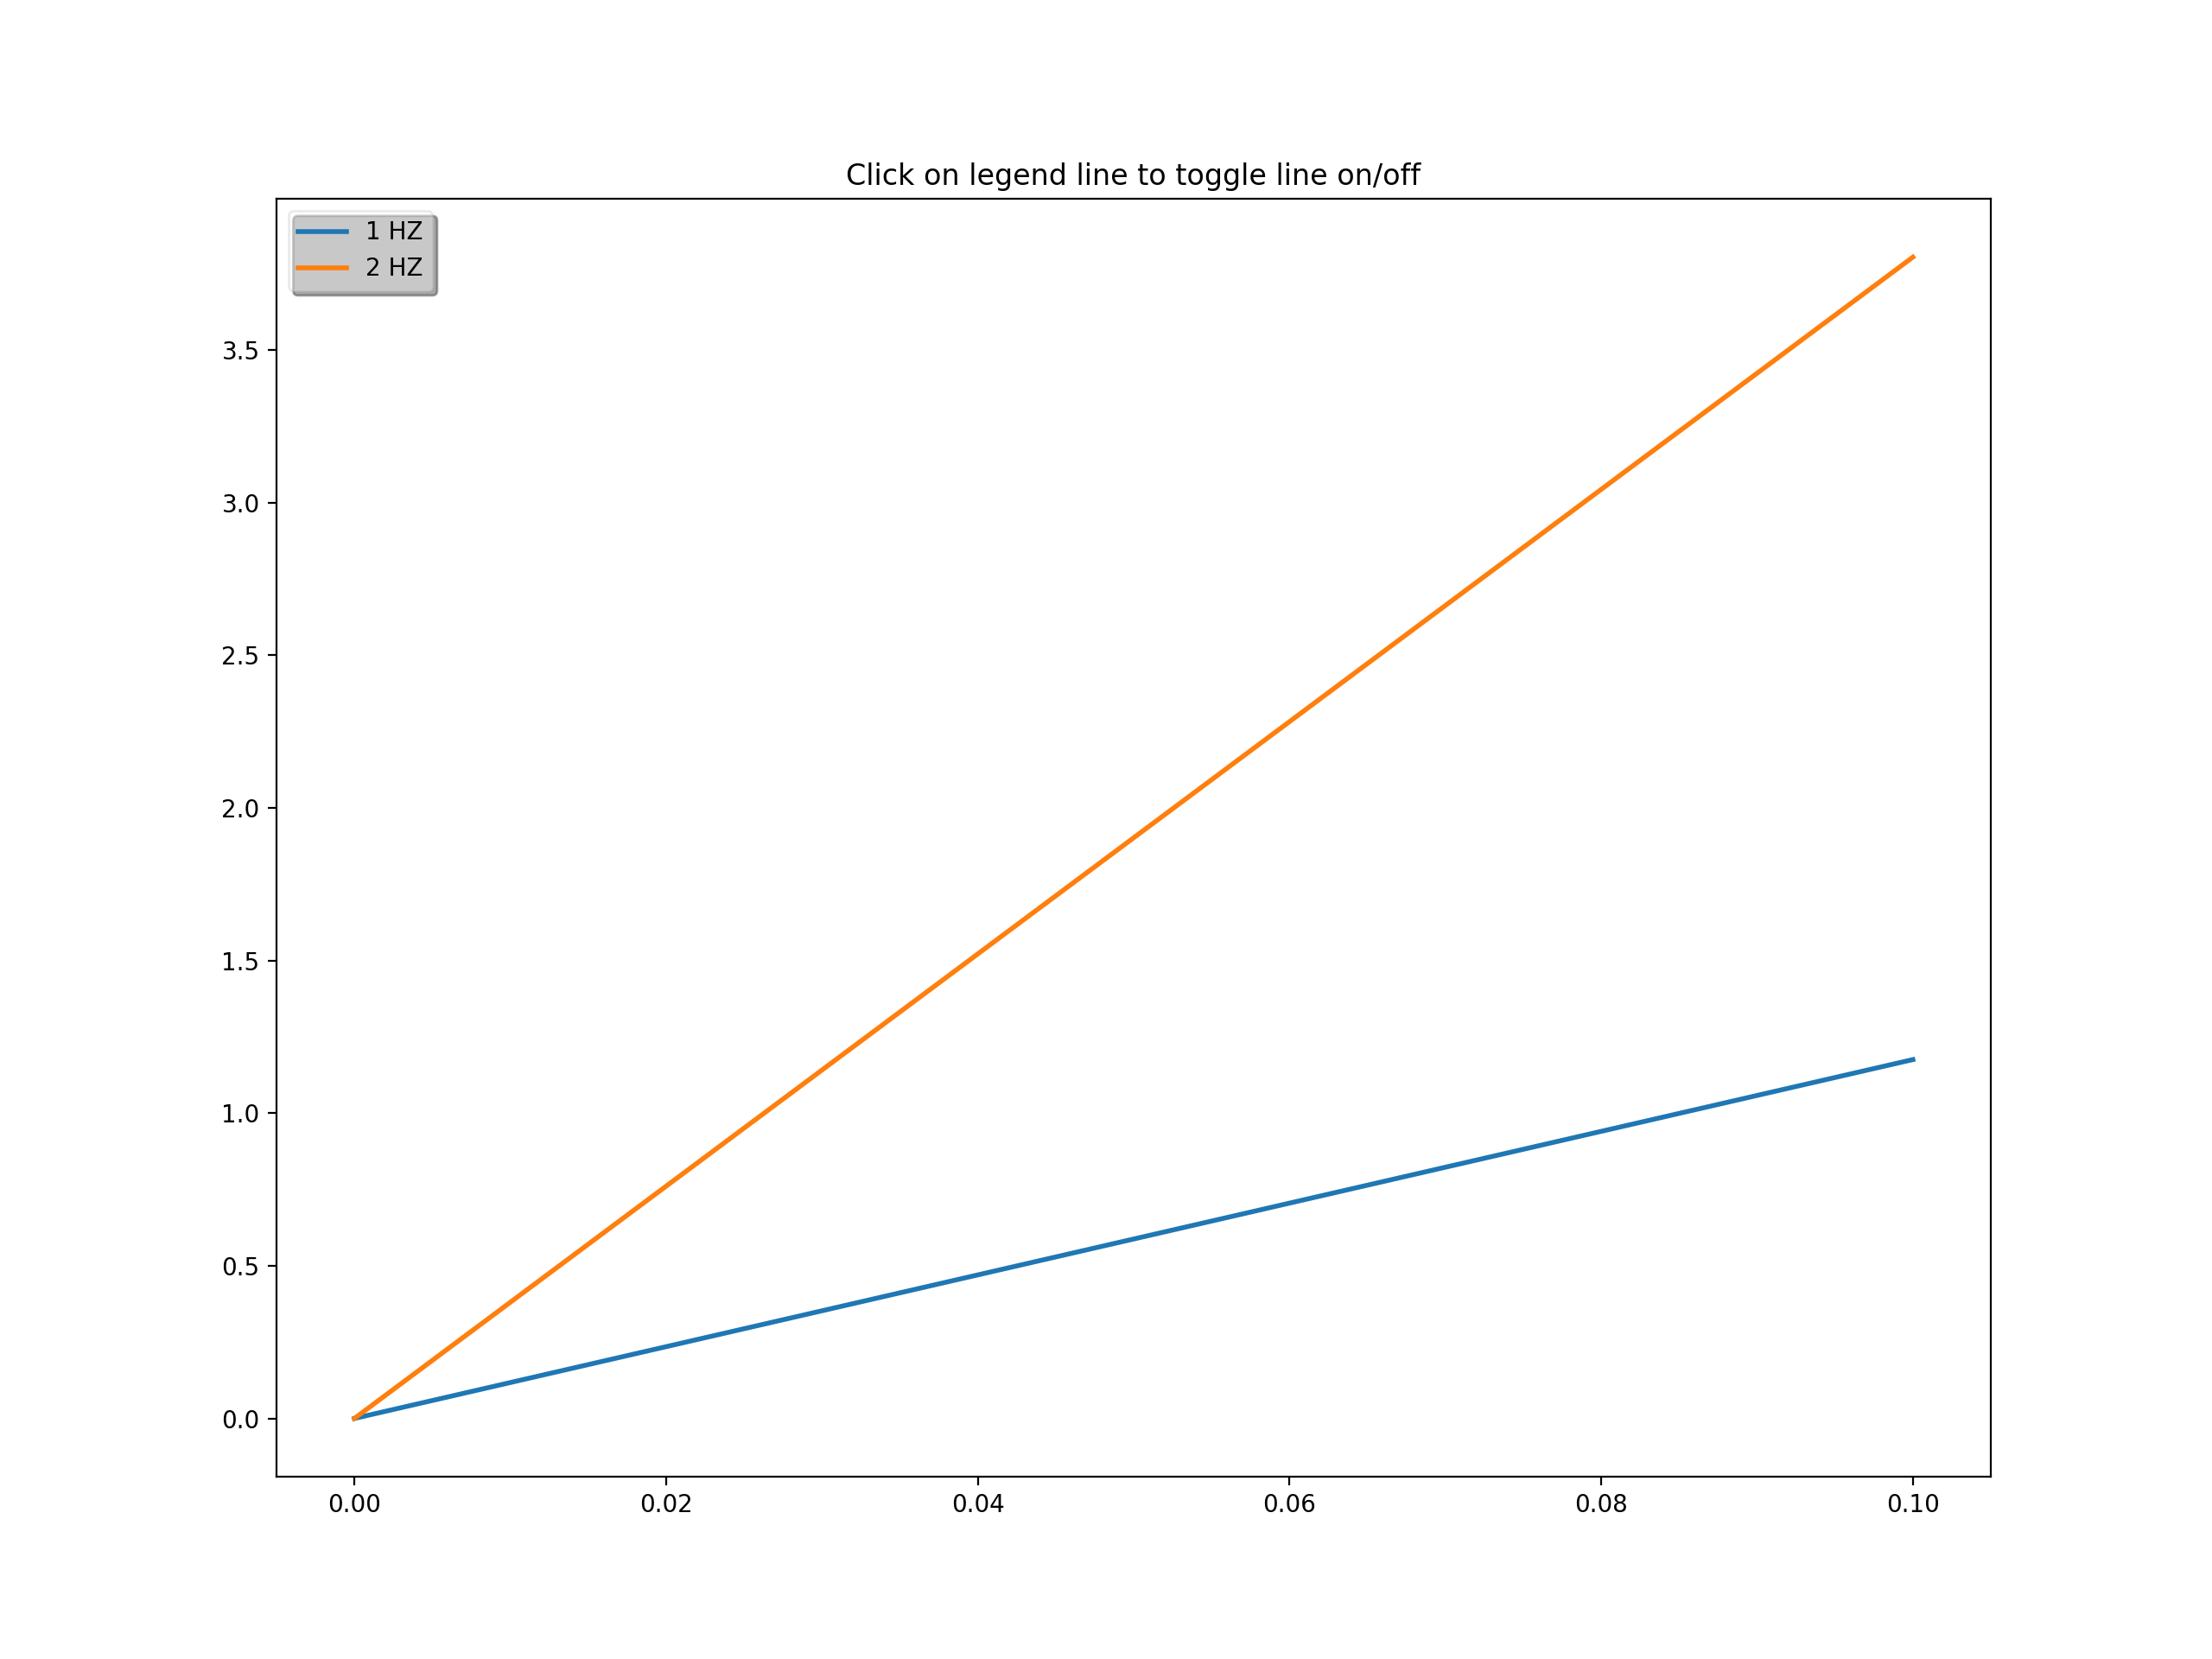

<ipython-input-1-f2b0d1745930>:20: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  legline.set_picker(5)  # 5 pts tolerance


In [1]:
%pylab notebook

t = np.arange(0.0, 0.2, 0.1)
y1 = 2*np.sin(2*np.pi*t)
y2 = 4*np.sin(2*np.pi*2*t)

fig, ax = plt.subplots()
ax.set_title('Click on legend line to toggle line on/off')
line1, = ax.plot(t, y1, lw=2, label='1 HZ')
line2, = ax.plot(t, y2, lw=2, label='2 HZ')
leg = ax.legend(loc='upper left', fancybox=True, shadow=True)
leg.get_frame().set_alpha(0.4)


# we will set up a dict mapping legend line to orig line, and enable
# picking on the legend line
lines = [line1, line2]
lined = dict()
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(5)  # 5 pts tolerance
    lined[legline] = origline


def onpick(event):
    # on the pick event, find the orig line corresponding to the
    # legend proxy line, and toggle the visibility
    legline = event.artist
    origline = lined[legline]
    vis = not origline.get_visible()
    origline.set_visible(vis)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled
    if vis:
        legline.set_alpha(1.0)
    else:
        legline.set_alpha(0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


In [107]:
print(lined)

{<matplotlib.lines.Line2D object at 0x00000251F2464580>: <matplotlib.lines.Line2D object at 0x00000251F2458C40>, <matplotlib.lines.Line2D object at 0x00000251F2464C40>: <matplotlib.lines.Line2D object at 0x00000251F2458E50>}


In [7]:
line3, = ax.plot(t, y2-1, lw=2, label='3 HZ')
legline= leg.get_lines()[-1]
legline.set_pickradius (5)  # 5 pts tolerance
lined[legline] = origline
fig.canvas.draw_idle()